In [1]:
import os
print(os.getcwd())  # check on JASMIN
import sys
dir_base = '/home/users/jamd1/Isca/'
sys.path.append(dir_base)
sys.path.append(os.path.abspath(os.path.join(dir_base, 'jobs/cesm/theory_adiabat/above_quant_2m_500hPa/')))
from save_info import load_raw_data         # useful function in `above_quant_2m_500hPa` directory
from isca_tools import cesm
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.ds_slicing import lat_lon_range_slice
from isca_tools.utils import get_memory_usage, len_safe
from isca_tools.utils.base import parse_int_list
from isca_tools.utils.xarray import set_attrs
from isca_tools.utils.constants import g
import sys
import os
import numpy as np
import f90nml
import warnings
import fnmatch
import logging
import time
import inspect
import xarray as xr
from typing import Optional, Union, List

/home/users/jamd1/Isca/jobs


In [2]:
# Load in script info, for ease of loading data
exp_name = 'test'
dir_quant = os.path.join(dir_base, f'jobs/cesm/theory_adiabat/above_quant_2m_500hPa/{exp_name}')
input_file_path = os.path.join(dir_quant, 'input_lev.nml')
input_info = f90nml.read(input_file_path)
script_info = input_info['script_info']

In [16]:
ds = load_raw_data(script_info['exp_name'], script_info['archive_dir'], script_info['plev_dir'], refht_level_index=script_info['refht_level_index'],
                   load_soilliq=False)
# get rid of Z info
var_keep = ['PS', 'TREFHT', 'QREFHT', 'PREFHT', 'T', 'p_at_lcl', 'T_at_lcl']
ds = ds[var_keep]

Loaded near-surface data
Loaded pressure-level data


In [18]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset(script_info['surf_geopotential_file'])[['LANDFRAC', 'PHIS']]
# invariant_data = invariant_data.sel(lat=slice(lat_min, lat_max))
invariant_data = invariant_data.reindex_like(ds['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))

In [19]:
# only consider land coordinates in top 5% of days at that location
quant = 95
quant_mask = xr.open_dataset(os.path.join(dir_quant, 'output_lev.nd2')).sel(quant=quant).use_in_calc
quant_mask = quant_mask.load()
mask_load = quant_mask>0

ds = ds.isel(plev=0).where(mask_load)
ds = ds.load()

In [47]:
int((~np.isnan(ds.time)).sum(dim='time')[0, 0])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [29]:
n_data = int((~np.isnan(ds.PS)).sum(dim='time')[0, 0])
print((~np.isnan(ds.PS)).sum(dim='time').std().values)      # sanity check that all lat and lon have same number of data points

0.0


In [40]:
data_out = {key: np.zeros((ds.lat.size, ds.lon.size, n_data)) for key in ds}
for i in range(ds.lat.size):
    for j in range(ds.lon.size):
        ind_use = np.where(~np.isnan(ds['T'].isel(lat=i, lon=j)))[0]
        for key in ds:
            data_out[key][i, j] = ds[key].isel(lat=i, lon=j, time=ind_use)

In [46]:
ds.time.dt.dayofyear

<xarray.DataArray 'dayofyear' (time: 4)> Size: 32B
array([2, 3, 4, 5])
Coordinates:
  * time     (time) object 32B 0031-01-02 00:00:00 ... 0031-01-05 00:00:00
    lev      float64 8B 957.5
    plev     int64 8B 50000
    quant    int64 8B 95
Attributes:
    long_name:  time
    bounds:     time_bnds

In [41]:
data_out

{'PS': array([[[ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ],
         [ 67539.90625  ]],
 
        [[100087.421875 ],
         [100122.84375  ],
         [100339.4453125],
         [ 99972.8125   ],
         [100693.125    ],
         [ 99617.90625  ],
         [101214.4140625],
         [101239.140625 ],
         [100152.8125   ],
         [ 99945.640625 ]],
 
        [[101083.5703125],
         [ 94693.6171875],
         [100778.3671875],
         [100133.2890625],
         [100769.5390625],
         [100699.0546875],
         [100876.8125   ],
         [100630.5390625],
         [101011.7265625],
         [100969.0390625]],
 
        [[ 99775.015625 ],
         [100974.1640625],
         [ 88991.6640625],
         [ 91866.7578125],
         [ 99889.953125 ],
         [101086.953125 ],
         [ 91

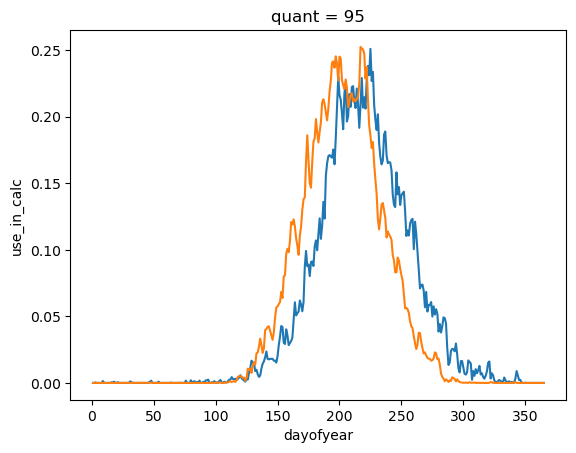

In [63]:
quant_mask.groupby('time.dayofyear').mean('time').where(ocean>0).mean(dim=['lon', 'lat']).plot()
quant_mask.groupby('time.dayofyear').mean('time').where(land>0).mean(dim=['lon', 'lat']).plot()
# quant_mask.groupby('time.dayofyear').mean('time').isel(lat=0, lon=3).plot()
# quant_mask.groupby('time.dayofyear').mean('time').isel(lat=0, lon=80).plot()

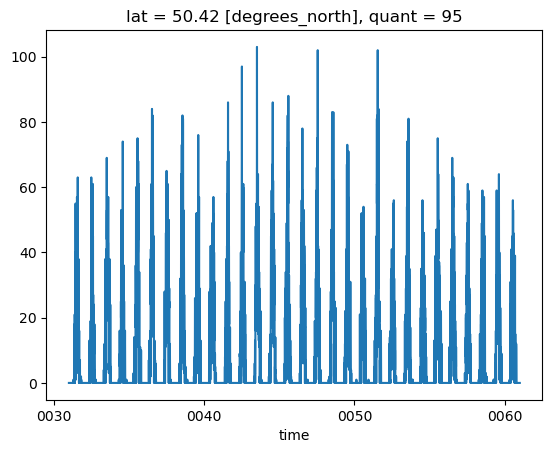

In [36]:
(land*quant_mask>0).isel(lat=0).sum(dim='lon').plot()

In [11]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:   (time: 730, lat: 3, lon: 288, plev: 1)
Coordinates:
  * lat       (lat) float64 24B 50.42 51.36 52.3
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lev       float64 8B 957.5
  * time      (time) object 6kB 0031-01-02 00:00:00 ... 0033-01-01 00:00:00
  * plev      (plev) int64 8B 50000
Data variables:
    PS        (time, lat, lon) float32 3MB 1.006e+05 1.004e+05 ... 1.022e+05
    TREFHT    (time, lat, lon) float32 3MB 276.5 276.4 276.1 ... 274.1 273.9
    QREFHT    (time, lat, lon) float32 3MB 0.003968 0.004047 ... 0.002656
    PREFHT    (time, lat, lon) float64 5MB 9.636e+04 9.616e+04 ... 9.786e+04
    T         (time, plev, lat, lon) float32 3MB 238.4 238.1 ... 247.0 246.2
    p_at_lcl  (lon, lat, time) float32 3MB 9.2e+04 9.4e+04 ... 9.5e+04 8.9e+04
    T_at_lcl  (time, lon, lat) float32 3MB 273.1 272.1 271.2 ... 267.5 267.0
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              e.e20.E1850TEST.f09_g17.daily_output
    logname:           jamd
    host:              ln01
    initial_file:      /work/n02/n02/jamd/cesm/CESM2.1.3/cesm_inputdata/atm/c...
    topography_file:   /work/n02/n02/jamd/cesm/CESM2.1.3/cesm_inputdata/atm/c...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

In [52]:
xr.open_dataset('/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/test/all_days/output_lev.nd2').TREFHT.isel(quant=0, sample=0).load()

<xarray.DataArray 'TREFHT' (lat: 5, lon: 10)> Size: 200B
array([[247.0681 , 247.06816, 247.06818, 247.06816, 247.06819, 247.06815,
        247.0681 , 247.0681 , 247.0681 , 247.0681 ],
       [282.81186, 280.36768, 286.00827, 279.32776, 286.5475 , 289.06555,
        281.79272, 284.01297, 286.51572, 283.08142],
       [297.96893, 296.21466, 297.93433, 298.75632, 298.23102, 296.95554,
        296.04712, 295.88205, 297.1706 , 297.65082],
       [279.14725, 277.09048, 270.4587 , 255.63516, 271.74603, 281.38968,
        271.9068 , 271.79352, 285.5909 , 279.8792 ],
       [245.7695 , 245.76962, 245.76949, 245.76952, 245.76956, 245.76967,
        245.76974, 245.76952, 245.76952, 245.7695 ]], dtype=float32)
Coordinates:
    quant    int64 8B 95
  * lat      (lat) float64 40B -90.0 -45.71 -0.4712 44.76 90.0
  * lon      (lon) float64 80B 0.0 38.75 78.75 118.8 ... 238.8 278.8 318.8 358.8
    sample   int64 8B 0
Attributes:
    long_name:  Temperature
    units:      K